# Import packages

In [1]:
#!/usr/bin/python
#-*- coding: utf-8 -*-

# >.>.>.>.>.>.>.>.>.>.>.>.>.>.>.>.
# Licensed under the Apache License, Version 2.0 (the "License")
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0

# --- File Name: eval_nav.py
# --- Creation Date: 16-02-2022
# --- Last Modified: Thu 17 Feb 2022 00:34:50 AEDT
# --- Author: Xinqi Zhu
# .<.<.<.<.<.<.<.<.<.<.<.<.<.<.<.<
"""
Evaluate Navigators with a pretrained attr discrim network.
"""
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from typing import List
import pickle
import click
import matplotlib.pyplot as plt
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F
import lpips

import legacy

In [2]:
generator_pkl = 'ffhq512'
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_atl_fixedES_neig30_ffhq512_1/00008-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedES-neig_30-afc_3-nfc_3-atl_14-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_1-kimg1000-batch28/network-snapshot-001000.pkl'
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pcabase_ffhq512/00002-ffhq512-z_50-lr_0.01-wals_1-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_none-nt_pca-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0-ncol_2-dys_T-vars_0.5-kimg80-batch6/network-snapshot-init.pkl'
attr_discrim_pkl = '/mnt/hpc_hdd_2/repo_results/stylegan2/results_vc2_byvae_ffhq512/00033-vc2_gan-ffhq-4gpu-config-c/converted_ps_sc/00000-convert/attr_discrim_model/00005-00012-pseudo_attr_data-attr-ch_3-dout_24-netn_resnet50-pretr_True-loss_reg-tsize_17000-kimg25000-batch64-noaug/network-snapshot-002016.pkl'

used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17] # more accurate

seed = 2022
#outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00028-ffhq512-z_10-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_16-dys_T-vars_0.5-kimg160-batch32/eval_nav'
# outdir = os.path.join(os.path.dirname(navigator_pkl), 'eval_nav')
outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/compare_navs'
n_samples_per = 1000
batch_gpu = 16
truncation_psi = 0.5

In [3]:
print('Loading generator networks from "%s"...' % generator_pkl)

resume_specs = {
    'ffhq256':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl',
    'ffhq512':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl',
    'ffhq1024':    'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl',
    'celebahq256': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/celebahq-res256-mirror-paper256-kimg100000-ada-target0.5.pkl',
    'lsundog256':  'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/lsundog-res256-paper256-kimg100000-noaug.pkl',
}

assert generator_pkl is not None
if generator_pkl in resume_specs:
    generator_pkl = resume_specs[generator_pkl] # predefined url

device = torch.device('cuda:0')
# device = torch.device('cpu')
with dnnlib.util.open_url(generator_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].requires_grad_(False).to(device) # type: ignore

def load_M(navigator_pkl):
    with open(navigator_pkl, 'rb') as f:
        resume_data = pickle.load(f)
        M = resume_data['M'].requires_grad_(False).to(device)
    return M

with open(attr_discrim_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    D = resume_data['D_ema'].requires_grad_(False).to(device)
print('Done loading.')

Loading generator networks from "ffhq512"...
Done loading.


In [16]:
print(D)

BackboneNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [4]:
os.makedirs(outdir, exist_ok=True)

In [5]:
def show(img):
    img = (img - img.min()) / (img.max() - img.min())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [6]:
def try_var_scale_ls(M, var_scale_ls, idx, used_dims, seed=0, truncation_psi=0.3):
    torch.random.manual_seed(seed)
    z = torch.randn([1, G.z_dim], device=device)
    c = torch.randn([1, G.c_dim], device=device)
    w = G.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)
    dirs = M(w) # [b, nv_dim, num_ws, w_dim]
    print('dirs.shape', dirs.shape)
    w_1 = w - dirs[:, used_dims[idx]] * var_scale_ls[idx]
    w_2 = w + dirs[:, used_dims[idx]] * var_scale_ls[idx] # [b, num_ws, w_dim]
    print(idx)
    image = G.synthesis(w_1, noise_mode='const')
    image_2 = G.synthesis(w_2, noise_mode='const')
    print(image.shape)

    show(torch.cat([image, image_2], dim=3)[0].cpu())
# try_var_scale_ls(M, var_scale_ls=[1] * M.nv_dim, idx=0, seed=20)

In [7]:
# Eval for each variation dim
# var_scale_ls = [5, 1, 1, 1, 5, 3, 1, 3, 5, 5]
#var_scale_ls = [1] * M.nv_dim

def evaluate_model(G, M, D, var_scale_ls=[2]*30, used_dims=[1,2,3], truncation_psi=0.5, n_samples_per=500):
    attr_score_shift_summary_ls = []
    img_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
    img_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
    rand_state = np.random.RandomState()
    for i, dim in enumerate(used_dims):
        attr_score_shift_ls = []
        print(f'Processing dim {i}')
        for j in range(0, n_samples_per, batch_gpu):
            b = batch_gpu if j+batch_gpu <= n_samples_per else n_samples_per-j

            z = torch.from_numpy(rand_state.randn(b, G.z_dim)).to(device)
            c = torch.from_numpy(rand_state.randn(b, G.c_dim)).to(device)
            w = G.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)

            dirs = M(w) # [b, nv_dim, num_ws, w_dim]
#             print('dirs.shape:', dirs.shape)
#             print('var_scale_ls:', var_scale_ls)
#             print('dim:', dim)
#             print('i:', i)
            w_1 = w - dirs[:, dim] * var_scale_ls[i]
            w_2 = w + dirs[:, dim] * var_scale_ls[i] # [b, num_ws, w_dim]

            images = torch.cat([G.synthesis(w_1, noise_mode='const'),
                                G.synthesis(w_2, noise_mode='const')], dim=0) # (2b, c, h, w)
        
            # Normalize to fit model D
            # images_flat = images.view(2*b, -1)
            # img_min, img_max = images_flat.min(dim=-1)[0], images_flat.max(dim=-1)[0]
            # images = (images - img_min.view(2*b, 1, 1, 1)) / (img_max - img_min).view(2*b, 1, 1, 1)
            images = (images + 1.) / 2. # From [-1, 1] to [0, 1]
            images = (images - img_mean) / img_std
        
            attr_pred = D(images) # [2b, nlabel]
            attr_score_shift = attr_pred[b:] - attr_pred[:b] # [b, nlabel]
            attr_score_shift_ls.append(attr_score_shift.to('cpu'))
        attr_score_shift_i = torch.cat(attr_score_shift_ls, dim=0).mean(0) # [nlabel]
        attr_score_shift_summary_ls.append(attr_score_shift_i)
    return attr_score_shift_summary_ls

In [8]:
def summarize(attr_score_shift_summary_ls, name='pca'):
    attr_score_shift_summary = torch.stack(attr_score_shift_summary_ls, dim=0) # [nv_dim, nlabel]
    print(attr_score_shift_summary.shape)

    scores_np = np.abs(attr_score_shift_summary.numpy())
    scores_normed = scores_np[:, used_attr_idx] / scores_np[:, used_attr_idx].max(axis=1, keepdims=True)
    
    scores_copy = scores_np.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:30, -1] - scores_copy[:30, -2]).mean()
    print('before normed:', score)
    
    scores_copy = scores_normed.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:30, -1] - scores_copy[:30, -2]).mean()
    print('after normed:', score)
    
    attr_discovered = (scores_normed == 1.).any(axis=0)
    n_discovered = attr_discovered.sum()
    print('attr_discovered:', attr_discovered)
    print('n_discovered:', n_discovered)
    
    plt.clf()
    plt.imshow(scores_normed[:30], cmap='viridis')
    # plt.imshow(scores_np[:30], cmap='viridis')
    plt.colorbar()
    #plt.show()
    plt.savefig(os.path.join(outdir, f'attr_score_shift_{name}.pdf'))
    np.savetxt(os.path.join(outdir, f"scores_raw_{name}.csv"), scores_np, delimiter=",")
    np.savetxt(os.path.join(outdir, f"scores_normed_{name}.csv"), scores_normed, delimiter=",")
    np.savetxt(os.path.join(outdir, f"score_{name}.csv"), score[np.newaxis], delimiter=",")
    np.savetxt(os.path.join(outdir, f"n_discovered_{name}.csv"), n_discovered[np.newaxis], delimiter=",")
    return score

In [9]:
# used_dims = argsort_percept(G, M, D)
def argsort_percept(G, M, n_samples_dim=100):
    pnet = lpips.LPIPS(net='alex', lpips=False).to(device)
    img_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
    img_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
    rand_state = np.random.RandomState()
    percept_ls = []
    for i in range(M.nv_dim):
        print('computing dim:', i)
        diff_ls_i = []
        for j in range(0, n_samples_dim, batch_gpu):
            b = batch_gpu if j+batch_gpu <= n_samples_per else n_samples_per-j

            z = torch.from_numpy(rand_state.randn(b, G.z_dim)).to(device)
            c = torch.from_numpy(rand_state.randn(b, G.c_dim)).to(device)
            w = G.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)

            #print(M.device)
            print(w.device)
            dirs = M(w) # [b, nv_dim, num_ws, w_dim]
            w_1 = w - dirs[:, i]
            w_2 = w + dirs[:, i] # [b, num_ws, w_dim]

            images = torch.cat([G.synthesis(w_1, noise_mode='const'),
                                G.synthesis(w_2, noise_mode='const')], dim=0) # (2b, c, h, w)
        
            # Normalize to fit model D
            # images_flat = images.view(2*b, -1)
            # img_min, img_max = images_flat.min(dim=-1)[0], images_flat.max(dim=-1)[0]
            # images = (images - img_min.view(2*b, 1, 1, 1)) / (img_max - img_min).view(2*b, 1, 1, 1)
            images = (images + 1.) / 2. # From [-1, 1] to [0, 1]
            images = (images - img_mean) / img_std
            
            diff = pnet(images[:b], images[b:]).squeeze() # [b]
            diff_ls_i.append(diff.to('cpu'))
        print(diff_ls_i)
        diff_i_sum = torch.cat(diff_ls_i, dim=0).sum()
        percept_ls.append(diff_i_sum)
    percept = torch.tensor(percept_ls, device=device)
    _, idx_sort = torch.sort(percept, descending=True)
    return idx_sort
        

In [93]:
attr_names = ['azimuth',#0
                'haircolor',#1
                'smile',#2
                'gender',#3
                'main_fringe',#4
                'left_fringe',#5
                'age',#6
                'light_right',#7
                'light_left',#8
                'light_vertical',#9
                'hair_style',#10
                'clothes_color',#11
                'saturation',#12
                'ambient_color',#13
                'elevation',#14
                'neck',#15
                'right_shoulder',#16
                'left_shoulder',#17
                'background_1',#18
                'background_2',#19
                'background_3',#20
                'background_4',#21
                'right_object',#22
                'left_object']#23
# used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17] # more accurate
used_attr_idx = list(range(24))
# === contra-1 not goood
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_atl_fixedES_neig30_ffhq512_1/00008-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedES-neig_30-afc_3-nfc_3-atl_14-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_1-kimg1000-batch28/network-snapshot-001000.pkl'
# === contra-2
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_fixedE100_ffhq512_1/00004-ffhq512-z_50-lr_0.05-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedE-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_3-kimg600-batch10/network-snapshot-000600.pkl'
# === pca_base
navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pcabase_ffhq512/00002-ffhq512-z_50-lr_0.01-wals_1-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_none-nt_pca-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0-ncol_2-dys_T-vars_0.5-kimg80-batch6/network-snapshot-init.pkl'
# === sefa_base
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_sefabase_ffhq512/00000-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_none-nt_sefa-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg1-batch24/network-snapshot-init.pkl'
# === recog-at_fixed-nv_fixed
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_recogbase_ffhq512/00002-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-mcont_0-sensor_alex-Rpre_T-recg_1-vs_0.25-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixed-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg1000-batch8/network-snapshot-001000.pkl'
M = load_M(navigator_pkl)
print('Done')

Done


In [94]:
used_dims = argsort_percept(G, M, n_samples_dim=20) # [4,2,6,10]
print('used_dims:', used_dims)

Setting up [baseline] perceptual loss: trunk [alex], v[0.1], spatial [off]
computing dim: 0
cuda:0
cuda:0
[tensor([2.7973, 4.5864, 2.6082, 2.6738, 4.6732, 2.5613, 4.1915, 4.7334, 4.4519,
        2.9410, 3.1496, 2.5624, 3.4079, 3.9313, 3.5983, 3.4296]), tensor([2.7936, 2.8886, 3.1214, 3.1894, 4.2420, 3.0697, 1.4965, 3.9604, 4.3591,
        3.4856, 4.6249, 4.1625, 2.0861, 3.2492, 4.3069, 3.7663])]
computing dim: 1
cuda:0
cuda:0
[tensor([4.2340, 3.8497, 3.5970, 3.9610, 3.4276, 4.1775, 4.4916, 3.5728, 4.1847,
        4.0259, 3.9383, 4.5730, 3.7645, 3.6041, 4.8350, 3.2495]), tensor([4.2187, 4.0007, 3.5325, 3.0337, 3.5768, 3.9966, 4.1714, 3.3058, 3.4830,
        3.8398, 4.1268, 3.7543, 4.6381, 3.6981, 4.1585, 4.1855])]
computing dim: 2
cuda:0
cuda:0
[tensor([4.5488, 4.3072, 4.7486, 4.6655, 5.2397, 4.4901, 3.6148, 3.9027, 3.5649,
        3.1075, 3.7023, 4.2938, 4.4864, 4.3254, 4.0237, 4.3707]), tensor([3.7730, 4.6308, 4.3471, 3.5723, 3.9910, 3.7640, 3.5448, 4.1161, 4.3587,
        4.0729, 4.2

cuda:0
[tensor([2.1664, 2.5559, 2.6656, 2.6259, 1.4566, 2.4219, 3.1722, 2.5192, 1.7964,
        1.7778, 2.1881, 1.7585, 2.4234, 2.4611, 1.6452, 1.5532]), tensor([2.6679, 2.4835, 1.7892, 2.3629, 2.8474, 2.6258, 2.2550, 2.2053, 1.9341,
        2.1884, 1.7519, 2.3451, 2.4231, 2.5014, 2.4161, 2.5521])]
computing dim: 26
cuda:0
cuda:0
[tensor([2.4030, 2.9562, 2.8356, 2.3249, 1.9386, 2.5771, 3.3204, 3.1433, 2.3627,
        2.9389, 2.9604, 2.5602, 1.6877, 2.4324, 2.8337, 3.0897]), tensor([2.3018, 3.4083, 2.0696, 2.4534, 2.8969, 2.0527, 2.7918, 2.7132, 2.4055,
        3.3132, 1.6405, 2.2187, 2.7509, 3.4129, 2.9309, 2.0612])]
computing dim: 27
cuda:0
cuda:0
[tensor([2.2509, 3.0265, 3.0183, 2.8398, 3.1004, 1.9495, 1.6059, 1.7316, 1.5840,
        2.0390, 2.6725, 1.9206, 1.8134, 2.9931, 2.7784, 1.6173]), tensor([1.9754, 2.4635, 1.7119, 2.5390, 2.6238, 2.4262, 2.4960, 1.6985, 2.3154,
        2.3459, 2.9019, 2.1896, 1.6571, 1.7033, 2.3006, 2.2641])]
computing dim: 28
cuda:0
cuda:0
[tensor([3.3722, 1

dirs.shape torch.Size([1, 50, 16, 512])
29
torch.Size([1, 3, 512, 512])


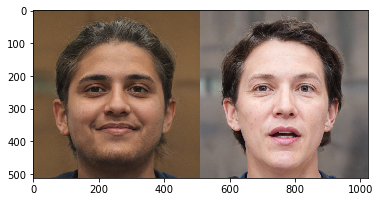

In [96]:
pca_used_dims = used_dims
pca_var_scale_ls = [3,3,3,3,3,3,
                   2,2,2,2,2,2,
                   2,2,2,2,2,2,
                   2,2,2,2,2,2,
                   2,2,2,2,2,2]
try_var_scale_ls(M, var_scale_ls=pca_var_scale_ls, used_dims=pca_used_dims, idx=29, seed=2001)

# === contra-1
# contra_var_scale_ls = [0.5,5,5,0.5,0.5,1,
#                       1,0.5,0.5,1,0.5,0.5,
#                       0.5,5,1,0.5,0.5,1,
#                       5,1,3,1,0.5,1,
#                       0.5,0.5,3,1,0.5,1]
# try_var_scale_ls(M, var_scale_ls=contra_var_scale_ls, idx=3, seed=112)

# === contra-2
# contra2_used_dims = used_dims
# contra2_var_scale_ls = [0.5,0.5,0.5,0.5,0.7,0.5,
#                        0.5,0.5,1,1,0.5,0.7,
#                        0.5,1,1,0.5,1,1,
#                        0.5,0.5,0.7,0.5,0.5,1,
#                        0.5,1,0.5,0.7,1,0.7,]
# try_var_scale_ls(M, var_scale_ls=contra2_var_scale_ls, used_dims=contra2_used_dims, idx=29, seed=31)

# sefa_var_scale_ls = [2,3,4,3,3,3,
#                       3,3,3,3,2,2,
#                       2,2,1.5,1.5,1.5,1.5,
#                       1.5,1.5,1.5,1.5,1.5,1.5,
#                       1.5,1.5,1.5,1.5,1.5,1.5]
# try_var_scale_ls(M, var_scale_ls=sefa_var_scale_ls, idx=29, seed=2013)

# recog_var_scale_ls = [0.5,0.5,0.5,0.5,0.5,5,
#                       5,0.5,0.5,5,0.5,0.5,
#                       1,0.5,0.5,0.3,0.5,0.5,
#                       5,1,1,0.5,0.5,5,
#                       0.5,0.3,0.3,0.5,0.5,5]
# try_var_scale_ls(M, var_scale_ls=recog_var_scale_ls, idx=29, seed=2016)

In [ ]:
pca_attr_ls = evaluate_model(G, M, D, var_scale_ls=pca_var_scale_ls, used_dims=pca_used_dims[:len(pca_var_scale_ls)])
# contra_attr_ls = evaluate_model(G, M, D, var_scale_ls=contra_var_scale_ls, max_nv_dim=32)
# contra2_attr_ls = evaluate_model(G, M, D, var_scale_ls=contra2_var_scale_ls, used_dims=contra2_used_dims[:len(contra2_var_scale_ls)])
# sefa_attr_ls = evaluate_model(G, M, D, var_scale_ls=sefa_var_scale_ls, used_dims=list(range(30)))
# recog_attr_ls = evaluate_model(G, M, D, var_scale_ls=recog_var_scale_ls, used_dims=list(range(30)))

Processing dim 0
Processing dim 1
Processing dim 2
Processing dim 3
Processing dim 4
Processing dim 5
Processing dim 6
Processing dim 7
Processing dim 8
Processing dim 9
Processing dim 10


In [88]:
pca_score = summarize(pca_attr_ls, name='pca')

NameError: name 'pca_attr_ls' is not defined

torch.Size([30, 24])
before normed: 0.12764023
after normed: 0.29718867
attr_discovered: [ True  True  True False  True  True  True False  True False False False
  True False  True  True  True False  True False False  True False False]
n_discovered: 13


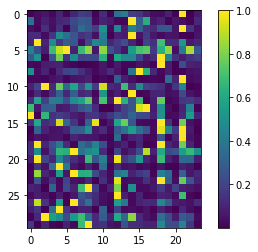

In [92]:
contra2_score = summarize(contra2_attr_ls, name='contra')

torch.Size([15, 24])
before normed: 0.1288536
after normed: 0.22934034
attr_discovered: [ True False False  True  True False False  True  True  True False False
  True False False]
n_discovered: 7


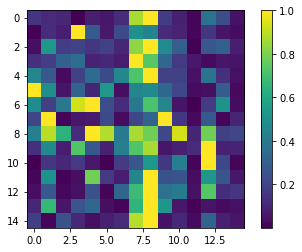

In [751]:
sefa_score = summarize(sefa_attr_ls[:15])

torch.Size([15, 24])
before normed: 0.103462
after normed: 0.36717668
attr_discovered: [ True  True  True  True  True False False  True  True False False False
 False False False]
n_discovered: 7


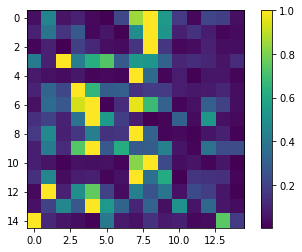

In [752]:
recog_score = summarize(recog_attr_ls[:15], name='recog')